In [1]:
# This code comes from the github repo https://github.com/matterport/Mask_RCNN under samples/nucleus
# The only changes we made were from loading up our own tumor datas

# Inspect Nucleus Training Data

Inspect and visualize data loading and pre-processing code.

https://www.kaggle.com/c/data-science-bowl-2018

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
import time
import concurrent.futures
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import imgaug
from imgaug import augmenters as iaa

# Root directory of the project
ROOT_DIR = os.getcwd()
if ROOT_DIR.endswith("samples/nucleus"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))
    
# Import Mask RCNN
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log

import nucleus

%matplotlib inline 

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Comment out to reload imported modules if they change
# %load_ext autoreload
# %autoreload 2

In [29]:
"""
Mask R-CNN
Train on the nuclei segmentation dataset from the
Kaggle 2018 Data Science Bowl
https://www.kaggle.com/c/data-science-bowl-2018/

Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla

------------------------------------------------------------

Usage: import the module (see Jupyter notebooks for examples), or run from
       the command line as such:

    # Train a new model starting from ImageNet weights
    python3 nucleus.py train --dataset=/path/to/dataset --subset=train --weights=imagenet

    # Train a new model starting from specific weights file
    python3 nucleus.py train --dataset=/path/to/dataset --subset=train --weights=/path/to/weights.h5

    # Resume training a model that you had trained earlier
    python3 nucleus.py train --dataset=/path/to/dataset --subset=train --weights=last

    # Generate submission file
    python3 nucleus.py detect --dataset=/path/to/dataset --subset=train --weights=<last or /path/to/weights.h5>
"""

# Set matplotlib backend
# This has to be done before other importa that might
# set it, but only if we're running in script mode
# rather than being imported.
if __name__ == '__main__':
    import matplotlib
    # Agg backend runs without a display
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt

import os
import sys
import json
import datetime
import numpy as np
import skimage.io
from imgaug import augmenters as iaa

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

# Results directory
# Save submission files here
RESULTS_DIR = os.path.join(ROOT_DIR, "results/nucleus/")

# The dataset doesn't have a standard train/val split, so I picked
# a variety of images to surve as a validation set.
VAL_IMAGE_IDS = [
    "0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2",
    "92f31f591929a30e4309ab75185c96ff4314ce0a7ead2ed2c2171897ad1da0c7",
    "1e488c42eb1a54a3e8412b1f12cde530f950f238d71078f2ede6a85a02168e1f",
    "c901794d1a421d52e5734500c0a2a8ca84651fb93b19cec2f411855e70cae339",
    "8e507d58f4c27cd2a82bee79fe27b069befd62a46fdaed20970a95a2ba819c7b",
    "60cb718759bff13f81c4055a7679e81326f78b6a193a2d856546097c949b20ff",
    "da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844",
    "9ebcfaf2322932d464f15b5662cae4d669b2d785b8299556d73fffcae8365d32",
    "1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df",
    "97126a9791f0c1176e4563ad679a301dac27c59011f579e808bbd6e9f4cd1034",
    "e81c758e1ca177b0942ecad62cf8d321ffc315376135bcbed3df932a6e5b40c0",
    "f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81",
    "0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1",
    "3ab9cab6212fabd723a2c5a1949c2ded19980398b56e6080978e796f45cbbc90",
    "ebc18868864ad075548cc1784f4f9a237bb98335f9645ee727dac8332a3e3716",
    "bb61fc17daf8bdd4e16fdcf50137a8d7762bec486ede9249d92e511fcb693676",
    "e1bcb583985325d0ef5f3ef52957d0371c96d4af767b13e48102bca9d5351a9b",
    "947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050",
    "cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9d3fc0c214a4e5d32bd",
    "f4c4db3df4ff0de90f44b027fc2e28c16bf7e5c75ea75b0a9762bbb7ac86e7a3",
    "4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06",
    "f73e37957c74f554be132986f38b6f1d75339f636dfe2b681a0cf3f88d2733af",
    "a4c44fc5f5bf213e2be6091ccaed49d8bf039d78f6fbd9c4d7b7428cfcb2eda4",
    "cab4875269f44a701c5e58190a1d2f6fcb577ea79d842522dcab20ccb39b7ad2",
    "8ecdb93582b2d5270457b36651b62776256ade3aaa2d7432ae65c14f07432d49",
]


############################################################
#  Configurations
############################################################

class TumorConfig(Config):
    """Configuration for training on the nucleus segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "tumor"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 6

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + nucleus

    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = (657 - len(VAL_IMAGE_IDS)) // IMAGES_PER_GPU
    VALIDATION_STEPS = max(1, len(VAL_IMAGE_IDS) // IMAGES_PER_GPU)

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_MIN_SCALE = 2.0

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    MEAN_PIXEL = np.array([54.78, 54.78, 54.78])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 200

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 400


class TumorInferenceConfig(NucleusConfig):
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Don't resize imager for inferencing
    IMAGE_RESIZE_MODE = "pad64"
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7


############################################################
#  Dataset
############################################################

class TumorDataset(utils.Dataset):

    def load_tumor(self, dataset_dir, subset):
        """Load a subset of the nuclei dataset.

        dataset_dir: Root directory of the dataset
        subset: Subset to load. Either the name of the sub-directory,
                such as stage1_train, stage1_test, ...etc. or, one of:
                * train: stage1_train excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """
        # Add classes. We have one class.
        # Naming the dataset nucleus, and the class nucleus
        self.add_class("tumor", 1, "tumor")

        # Which subset?
        # "val": use hard-coded list above
        # "train": use data from stage1_train minus the hard-coded list above
        # else: use the data from the specified sub-directory
#       assert subset in ["train", "val", "stage1_train", "stage1_test", "stage2_test"]
#         subset_dir = "stage1_train" if subset in ["train", "val"] else subset
        dataset_dir = os.path.join(dataset_dir, subset)
        # Get image ids from directory names
        image_ids = next(os.walk(dataset_dir))[1]
        print(len(image_ids))
#         if subset == "train":
#             image_ids = list(set(image_ids) - set(VAL_IMAGE_IDS))

        # Add images
        for im_id_num in image_ids:
            image_id_str = str(im_id_num) + '_' + subset
            self.add_image(
                "tumor",
                image_id=image_id_str,
                path=os.path.join(dataset_dir, im_id_num, "{}.png".format(image_id_str)))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        # Get mask directory from image path
        mask_dir = os.path.join(os.path.dirname(info['path']), "mask")

        # Read mask files from .png image
        mask = []
        print(mask_dir)
        for f in os.listdir(mask_dir):
            if f.endswith(".png"):
                m = skimage.io.imread(os.path.join(mask_dir, f)).astype(np.bool)
                mask.append(m)
        mask = np.stack(mask, axis=-1)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)


############################################################
#  Training
############################################################

def train(model, dataset_dir, subset):
    """Train the model."""
    # Training dataset.
    dataset_train = TumorDataset()
    dataset_train.load_tumor(dataset_dir, subset)
    dataset_train.prepare()

    # Validation dataset
    dataset_val = TumorDataset()
    dataset_val.load_tumor(dataset_dir, "val")
    dataset_val.prepare()

    # Image augmentation
    # http://imgaug.readthedocs.io/en/latest/source/augmenters.html
    augmentation = iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Multiply((0.8, 1.5)),
        iaa.GaussianBlur(sigma=(0.0, 5.0))
    ])

    # *** This training schedule is an example. Update to your needs ***

    # If starting from imagenet, train heads only for a bit
    # since they have random weights
    print("Train network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=20,
                augmentation=augmentation,
                layers='heads')

    print("Train all layers")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=40,
                augmentation=augmentation,
                layers='all')


############################################################
#  RLE Encoding
############################################################

def rle_encode(mask):
    """Encodes a mask in Run Length Encoding (RLE).
    Returns a string of space-separated values.
    """
    assert mask.ndim == 2, "Mask must be of shape [Height, Width]"
    # Flatten it column wise
    m = mask.T.flatten()
    # Compute gradient. Equals 1 or -1 at transition points
    g = np.diff(np.concatenate([[0], m, [0]]), n=1)
    # 1-based indicies of transition points (where gradient != 0)
    rle = np.where(g != 0)[0].reshape([-1, 2]) + 1
    # Convert second index in each pair to lenth
    rle[:, 1] = rle[:, 1] - rle[:, 0]
    return " ".join(map(str, rle.flatten()))


def rle_decode(rle, shape):
    """Decodes an RLE encoded list of space separated
    numbers and returns a binary mask."""
    rle = list(map(int, rle.split()))
    rle = np.array(rle, dtype=np.int32).reshape([-1, 2])
    rle[:, 1] += rle[:, 0]
    rle -= 1
    mask = np.zeros([shape[0] * shape[1]], np.bool)
    for s, e in rle:
        assert 0 <= s < mask.shape[0]
        assert 1 <= e <= mask.shape[0], "shape: {}  s {}  e {}".format(shape, s, e)
        mask[s:e] = 1
    # Reshape and transpose
    mask = mask.reshape([shape[1], shape[0]]).T
    return mask


def mask_to_rle(image_id, mask, scores):
    "Encodes instance masks to submission format."
    assert mask.ndim == 3, "Mask must be [H, W, count]"
    # If mask is empty, return line with image ID only
    if mask.shape[-1] == 0:
        return "{},".format(image_id)
    # Remove mask overlaps
    # Multiply each instance mask by its score order
    # then take the maximum across the last dimension
    order = np.argsort(scores)[::-1] + 1  # 1-based descending
    mask = np.max(mask * np.reshape(order, [1, 1, -1]), -1)
    # Loop over instance masks
    lines = []
    for o in order:
        m = np.where(mask == o, 1, 0)
        # Skip if empty
        if m.sum() == 0.0:
            continue
        rle = rle_encode(m)
        lines.append("{}, {}".format(image_id, rle))
    return "\n".join(lines)


############################################################
#  Detection
############################################################

def detect(model, dataset_dir, subset):
    """Run detection on images in the given directory."""
    print("Running on {}".format(dataset_dir))

    # Create directory
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
    submit_dir = "submit_{:%Y%m%dT%H%M%S}".format(datetime.datetime.now())
    submit_dir = os.path.join(RESULTS_DIR, submit_dir)
    os.makedirs(submit_dir)

    # Read dataset
    dataset = TumorDataset()
    dataset.load_tumor(dataset_dir, subset)
    dataset.prepare()
    # Load over images
    submission = []
    for image_id in dataset.image_ids:
        # Load image and run detection
        image = dataset.load_image(image_id)
        # Detect objects
        r = model.detect([image], verbose=0)[0]
        # Encode image to RLE. Returns a string of multiple lines
        source_id = dataset.image_info[image_id]["id"]
        rle = mask_to_rle(source_id, r["masks"], r["scores"])
        submission.append(rle)
        # Save image with masks
        visualize.display_instances(
            image, r['rois'], r['masks'], r['class_ids'],
            dataset.class_names, r['scores'],
            show_bbox=False, show_mask=False,
            title="Predictions")
        plt.savefig("{}/{}.png".format(submit_dir, dataset.image_info[image_id]["id"]))

    # Save to csv file
    submission = "ImageId,EncodedPixels\n" + "\n".join(submission)
    file_path = os.path.join(submit_dir, "submit.csv")
    with open(file_path, "w") as f:
        f.write(submission)
    print("Saved to ", submit_dir)


############################################################
#  Command Line
############################################################



/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/shared/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/shared/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start


In [2]:
import imageio
from sklearn.model_selection import train_test_split
import os

x_cbis_path = './x_cbis.npy'
y_cbis_path = './y_cbis.npy'
out_dir = './cbis_dataset'

X = np.load(x_cbis_path)
Y = np.load(y_cbis_path)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.6,random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test,Y_test,train_size=0.5,random_state=42)

def save_im(X, Y, subdir):
    im_id = 0
    for i in range(X.shape[0]):
        im_x = X[i]
        im_y = Y[i]
        str_im_id = str(im_id) + '_' + subdir + '.png'
        filename = os.path.join(out_dir, subdir, str(im_id), str_im_id)
        filename_mask =  os.path.join(out_dir, subdir, str(im_id), 'mask', str_im_id)
        create_dir(filename)
        create_dir(filename_mask)
       
        imageio.imwrite(filename, im_x)
        imageio.imwrite(filename_mask, im_y)
        im_id += 1

def create_dir(filename):
     if not os.path.exists(os.path.dirname(filename)):
        try:
            os.makedirs(os.path.dirname(filename))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
        

save_im(X_train, Y_train, 'train')
save_im(X_test, Y_test, 'test')
save_im(X_val, Y_val, 'val')



    

/home/shared/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


1860
Image Count: 1860
Class Count: 2
  0. BG                                                
  1. tumor                                             
1307
./cbis_dataset/train/634/mask
(1024, 1024, 3)


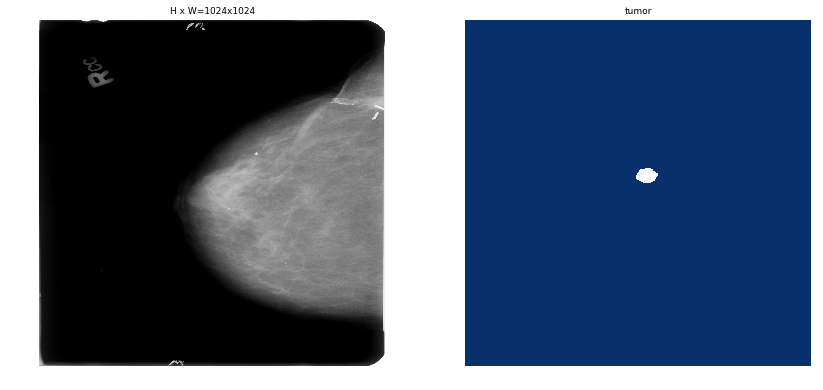

186
./cbis_dataset/train/1362/mask
(1024, 1024, 3)


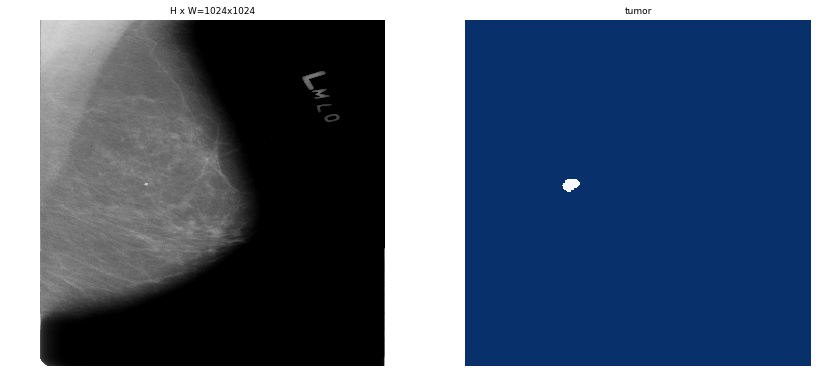

1145
./cbis_dataset/train/405/mask
(1024, 1024, 3)


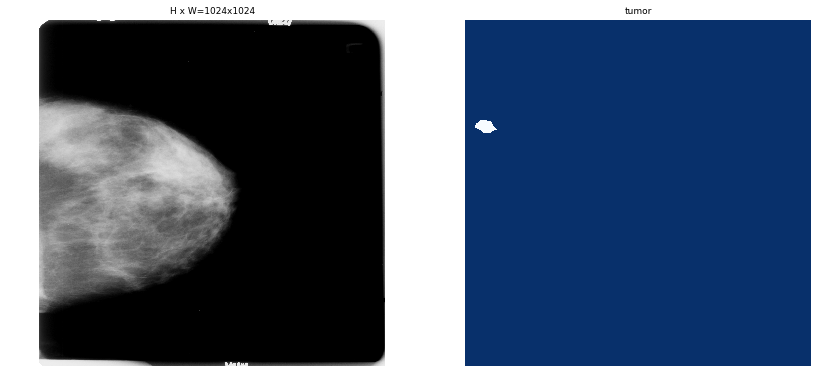

1465
./cbis_dataset/train/1051/mask
(1024, 1024, 3)


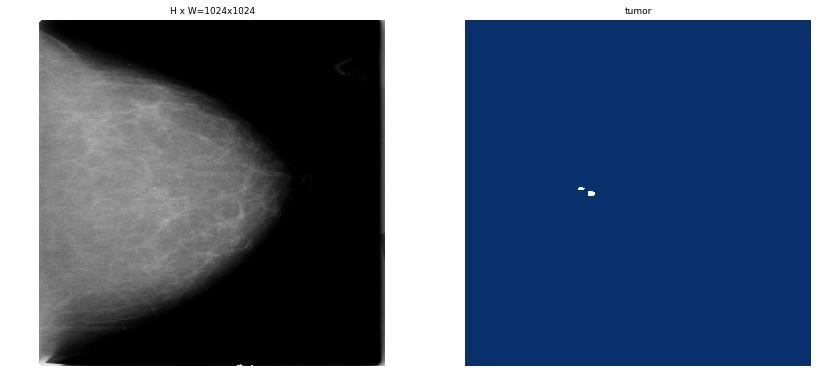

In [30]:
dataset = TumorDataset()
# The subset is the name of the sub-directory, such as stage1_train,
# stage1_test, ...etc. You can also use these special values:
#     train: loads stage1_train but excludes validation images
#     val: loads validation images from stage1_train. For a list
#          of validation images see nucleus.py
DATASET_DIR = './cbis_dataset'
dataset.load_tumor(DATASET_DIR, subset="train")
dataset.prepare()
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    print(image_id)
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    print(image.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

## Configurations

In [31]:
# Dataset directory
#DATASET_DIR = os.path.join(ROOT_DIR, "datasets/nucleus")
DATASET_DIR = './cbis_dataset'

# Use configuation from nucleus.py, but override
# image resizing so we see the real sizes here
class NoResizeConfig(TumorConfig):
    IMAGE_RESIZE_MODE = "none"
    
config = NoResizeConfig()

## Notebook Preferences

In [32]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Download the dataset from the competition Website. Unzip it and save it in `mask_rcnn/datasets/nucleus`. If you prefer a different directory then change the `DATASET_DIR` variable above.

https://www.kaggle.com/c/data-science-bowl-2018/data

In [5]:
# Load dataset
dataset = nucleus.NucleusDataset()
# The subset is the name of the sub-directory, such as stage1_train,
# stage1_test, ...etc. You can also use these special values:
#     train: loads stage1_train but excludes validation images
#     val: loads validation images from stage1_train. For a list
#          of validation images see nucleus.py
dataset.load_nucleus(DATASET_DIR, subset="train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 639
Class Count: 2
  0. BG                                                
  1. nucleus                                           


## Display Samples

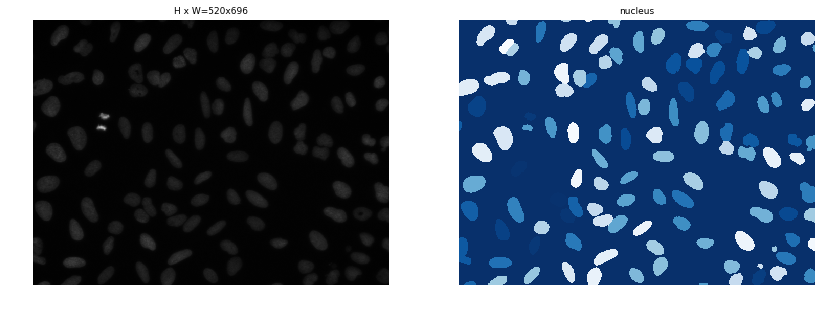

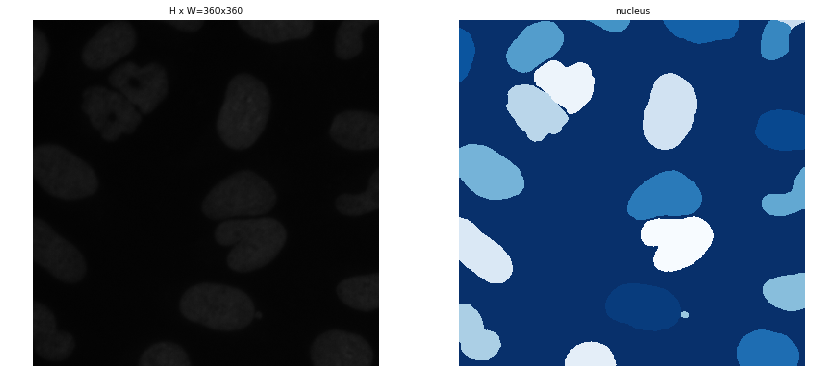

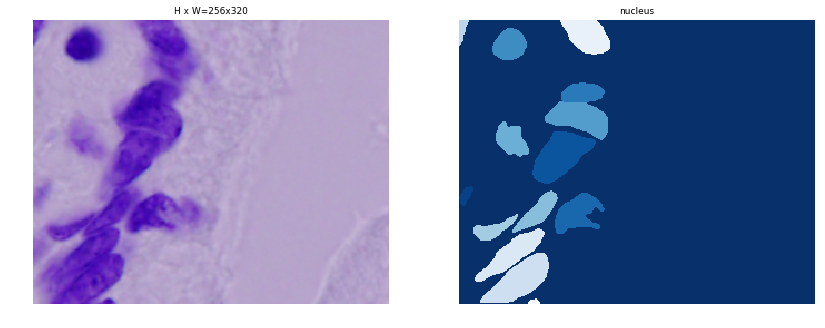

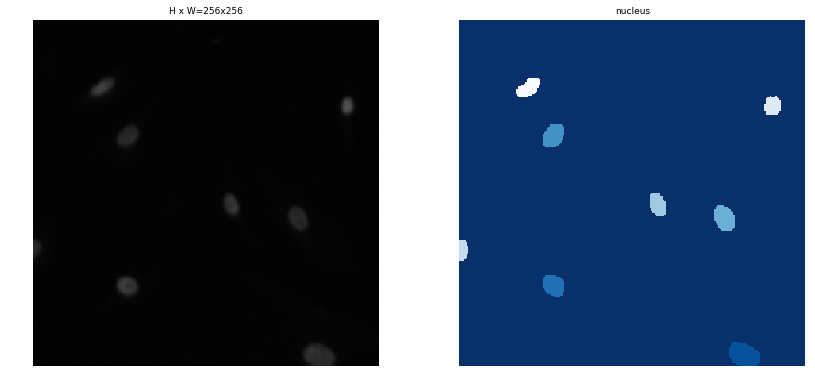

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

molded_image             shape: (256, 320, 3)         min:   28.00000  max:  232.00000  uint8
mask                     shape: (256, 320, 42)        min:    0.00000  max:    1.00000  bool


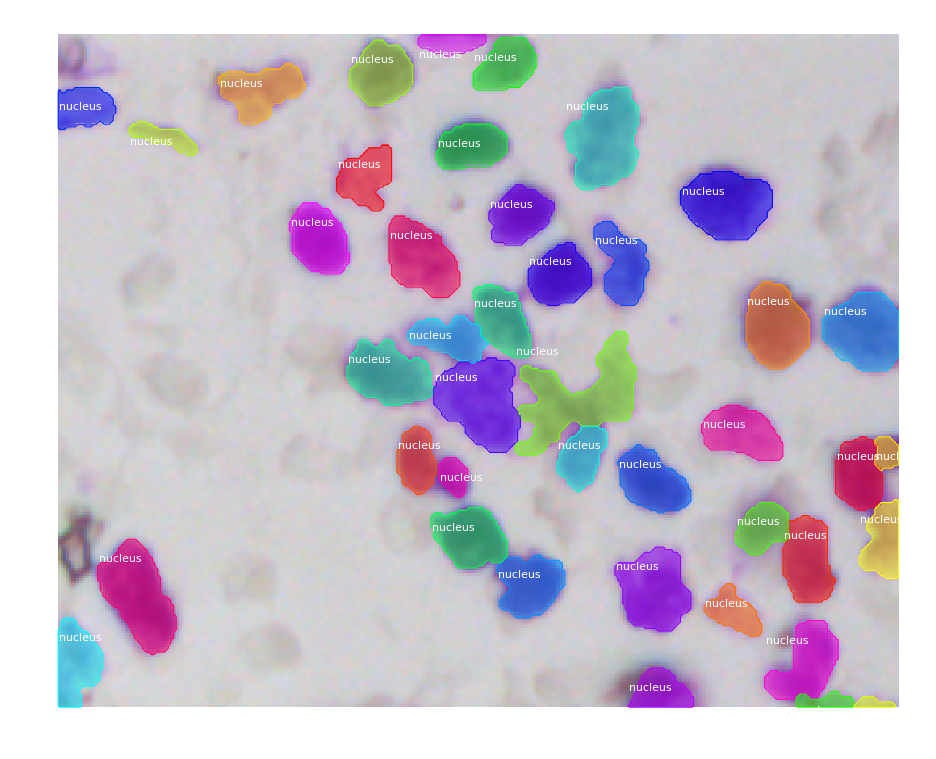

In [7]:
# Example of loading a specific image by its source ID
source_id = "ed5be4b63e9506ad64660dd92a098ffcc0325195298c13c815a73773f1efc279"

# Map source ID to Dataset image_id
# Notice the nucleus prefix: it's the name given to the dataset in NucleusDataset
image_id = dataset.image_from_source_map["nucleus.{}".format(source_id)]

# Load and display
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False)
log("molded_image", image)
log("mask", mask)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names,
                            show_bbox=False)

## Dataset Stats

Loop through all images in the dataset and collect aggregate stats.

In [11]:
def image_stats(image_id):
    """Returns a dict of stats for one image."""
    image = dataset.load_image(image_id)
    mask, _ = dataset.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    # Sanity check
    assert mask.shape[:2] == image.shape[:2]
    # Return stats dict
    return {
        "id": image_id,
        "shape": list(image.shape),
        "bbox": [[b[2] - b[0], b[3] - b[1]]
                 for b in bbox
                 # Uncomment to exclude nuclei with 1 pixel width
                 # or height (often on edges)
                 # if b[2] - b[0] > 1 and b[3] - b[1] > 1
                ],
        "color": np.mean(image, axis=(0, 1)),
    }

# Loop through the dataset and compute stats over multiple threads
# This might take a few minutes
t_start = time.time()
with concurrent.futures.ThreadPoolExecutor() as e:
    stats = list(e.map(image_stats, dataset.image_ids))
t_total = time.time() - t_start
print("Total time: {:.1f} seconds".format(t_total))

./cbis_dataset/train/1803/mask
./cbis_dataset/train/408/mask
./cbis_dataset/train/414/mask
./cbis_dataset/train/134/mask
./cbis_dataset/train/684/mask
./cbis_dataset/train/678/mask
./cbis_dataset/train/218/mask
./cbis_dataset/train/607/mask
./cbis_dataset/train/732/mask
./cbis_dataset/train/731/mask
./cbis_dataset/train/539/mask
./cbis_dataset/train/1014/mask./cbis_dataset/train/544/mask./cbis_dataset/train/1735/mask
./cbis_dataset/train/1729/mask


./cbis_dataset/train/133/mask
./cbis_dataset/train/343/mask
./cbis_dataset/train/824/mask
./cbis_dataset/train/1294/mask
./cbis_dataset/train/785/mask./cbis_dataset/train/1492/mask
./cbis_dataset/train/1165/mask

./cbis_dataset/train/468/mask
./cbis_dataset/train/377/mask
./cbis_dataset/train/1055/mask
./cbis_dataset/train/1415/mask
./cbis_dataset/train/480/mask
./cbis_dataset/train/704/mask
./cbis_dataset/train/1247/mask
./cbis_dataset/train/1807/mask
./cbis_dataset/train/1462/mask
./cbis_dataset/train/1421/mask
./cbis_dataset/train/1308/m

./cbis_dataset/train/150/mask
./cbis_dataset/train/1102/mask

./cbis_dataset/train/702/mask
./cbis_dataset/train/1164/mask
./cbis_dataset/train/130/mask./cbis_dataset/train/863/mask
./cbis_dataset/train/1834/mask
./cbis_dataset/train/585/mask
./cbis_dataset/train/1680/mask
./cbis_dataset/train/576/mask
./cbis_dataset/train/699/mask./cbis_dataset/train/310/mask./cbis_dataset/train/1189/mask
./cbis_dataset/train/1026/mask
./cbis_dataset/train/1137/mask


./cbis_dataset/train/410/mask./cbis_dataset/train/1531/mask
./cbis_dataset/train/1015/mask

./cbis_dataset/train/278/mask

./cbis_dataset/train/1417/mask
./cbis_dataset/train/1719/mask
./cbis_dataset/train/1737/mask
./cbis_dataset/train/1753/mask
./cbis_dataset/train/804/mask
./cbis_dataset/train/1192/mask./cbis_dataset/train/1564/mask./cbis_dataset/train/254/mask

./cbis_dataset/train/1259/mask./cbis_dataset/train/464/mask./cbis_dataset/train/1351/mask
./cbis_dataset/train/1184/mask

./cbis_dataset/train/1600/mask
./cbis_dataset/train/1

./cbis_dataset/train/392/mask

./cbis_dataset/train/1463/mask
./cbis_dataset/train/927/mask
./cbis_dataset/train/204/mask
./cbis_dataset/train/1199/mask
./cbis_dataset/train/1091/mask

./cbis_dataset/train/838/mask


./cbis_dataset/train/675/mask
./cbis_dataset/train/57/mask
./cbis_dataset/train/980/mask./cbis_dataset/train/521/mask
./cbis_dataset/train/970/mask./cbis_dataset/train/220/mask
./cbis_dataset/train/1240/mask
./cbis_dataset/train/803/mask
./cbis_dataset/train/1623/mask
./cbis_dataset/train/608/mask
./cbis_dataset/train/903/mask
./cbis_dataset/train/268/mask
./cbis_dataset/train/840/mask
./cbis_dataset/train/5/mask
./cbis_dataset/train/1677/mask
./cbis_dataset/train/1166/mask
./cbis_dataset/train/1356/mask
./cbis_dataset/train/493/mask

./cbis_dataset/train/1263/mask
./cbis_dataset/train/2/mask
./cbis_dataset/train/149/mask
./cbis_dataset/train/818/mask./cbis_dataset/train/1349/mask./cbis_dataset/train/1577/mask
./cbis_dataset/train/1686/mask

./cbis_dataset/train/1135/mask



./cbis_dataset/train/1739/mask./cbis_dataset/train/620/mask

./cbis_dataset/train/1543/mask
./cbis_dataset/train/1284/mask
./cbis_dataset/train/1533/mask./cbis_dataset/train/171/mask
./cbis_dataset/train/1112/mask

./cbis_dataset/train/1398/mask./cbis_dataset/train/982/mask./cbis_dataset/train/1289/mask./cbis_dataset/train/1692/mask

./cbis_dataset/train/831/mask

./cbis_dataset/train/1560/mask./cbis_dataset/train/342/mask./cbis_dataset/train/786/mask

./cbis_dataset/train/1454/mask

./cbis_dataset/train/1048/mask
./cbis_dataset/train/279/mask
./cbis_dataset/train/1631/mask
./cbis_dataset/train/213/mask
./cbis_dataset/train/1246/mask./cbis_dataset/train/323/mask./cbis_dataset/train/1661/mask
./cbis_dataset/train/325/mask

./cbis_dataset/train/795/mask

./cbis_dataset/train/438/mask

./cbis_dataset/train/1339/mask./cbis_dataset/train/141/mask
./cbis_dataset/train/1060/mask./cbis_dataset/train/1235/mask


./cbis_dataset/train/802/mask./cbis_dataset/train/168/mask./cbis_dataset/train/156


./cbis_dataset/train/1106/mask

./cbis_dataset/train/1303/mask

./cbis_dataset/train/1727/mask
./cbis_dataset/train/1474/mask
./cbis_dataset/train/1004/mask
./cbis_dataset/train/136/mask./cbis_dataset/train/908/mask
./cbis_dataset/train/870/mask

./cbis_dataset/train/1461/mask./cbis_dataset/train/25/mask

./cbis_dataset/train/707/mask./cbis_dataset/train/185/mask./cbis_dataset/train/1823/mask
./cbis_dataset/train/842/mask
./cbis_dataset/train/1281/mask
./cbis_dataset/train/417/mask
./cbis_dataset/train/1081/mask./cbis_dataset/train/1693/mask
./cbis_dataset/train/108/mask
./cbis_dataset/train/405/mask
./cbis_dataset/train/934/mask

./cbis_dataset/train/276/mask
./cbis_dataset/train/243/mask./cbis_dataset/train/1031/mask
./cbis_dataset/train/941/mask

./cbis_dataset/train/1521/mask
./cbis_dataset/train/1705/mask
./cbis_dataset/train/1391/mask
./cbis_dataset/train/420/mask


./cbis_dataset/train/1261/mask
./cbis_dataset/train/401/mask./cbis_dataset/train/446/mask
./cbis_dataset/train/137

./cbis_dataset/train/479/mask


./cbis_dataset/train/54/mask
./cbis_dataset/train/1668/mask
./cbis_dataset/train/1006/mask
./cbis_dataset/train/640/mask
./cbis_dataset/train/488/mask./cbis_dataset/train/123/mask./cbis_dataset/train/605/mask
./cbis_dataset/train/295/mask
./cbis_dataset/train/1710/mask
./cbis_dataset/train/1343/mask
./cbis_dataset/train/109/mask
./cbis_dataset/train/1377/mask


./cbis_dataset/train/1079/mask
./cbis_dataset/train/1324/mask
./cbis_dataset/train/1707/mask
./cbis_dataset/train/470/mask
./cbis_dataset/train/469/mask./cbis_dataset/train/1740/mask
./cbis_dataset/train/735/mask
./cbis_dataset/train/1147/mask
./cbis_dataset/train/583/mask
./cbis_dataset/train/782/mask
./cbis_dataset/train/426/mask
./cbis_dataset/train/1142/mask

./cbis_dataset/train/12/mask
./cbis_dataset/train/1370/mask./cbis_dataset/train/1051/mask
./cbis_dataset/train/95/mask
./cbis_dataset/train/668/mask
./cbis_dataset/train/1653/mask
./cbis_dataset/train/880/mask
./cbis_dataset/train/1816/ma

./cbis_dataset/train/1717/mask./cbis_dataset/train/1319/mask
./cbis_dataset/train/429/mask
./cbis_dataset/train/1846/mask
./cbis_dataset/train/1084/mask
./cbis_dataset/train/88/mask
./cbis_dataset/train/1085/mask
./cbis_dataset/train/556/mask
./cbis_dataset/train/773/mask
./cbis_dataset/train/1569/mask

./cbis_dataset/train/97/mask
./cbis_dataset/train/47/mask./cbis_dataset/train/1484/mask
./cbis_dataset/train/1105/mask
./cbis_dataset/train/1083/mask
./cbis_dataset/train/547/mask
./cbis_dataset/train/1276/mask./cbis_dataset/train/1840/mask
./cbis_dataset/train/1599/mask./cbis_dataset/train/688/mask
./cbis_dataset/train/1519/mask

./cbis_dataset/train/996/mask

./cbis_dataset/train/611/mask
./cbis_dataset/train/1472/mask
./cbis_dataset/train/781/mask
./cbis_dataset/train/855/mask./cbis_dataset/train/1272/mask
./cbis_dataset/train/848/mask

./cbis_dataset/train/933/mask./cbis_dataset/train/628/mask

./cbis_dataset/train/72/mask
./cbis_dataset/train/664/mask
./cbis_dataset/train/1120/mask

### Image Size Stats

Image Count:  1860
Height  mean: 1024.00  median: 1024.00  min: 1024.00  max: 1024.00
Width   mean: 1024.00  median: 1024.00  min: 1024.00  max: 1024.00
Color   mean (RGB): 54.78 54.78 54.78


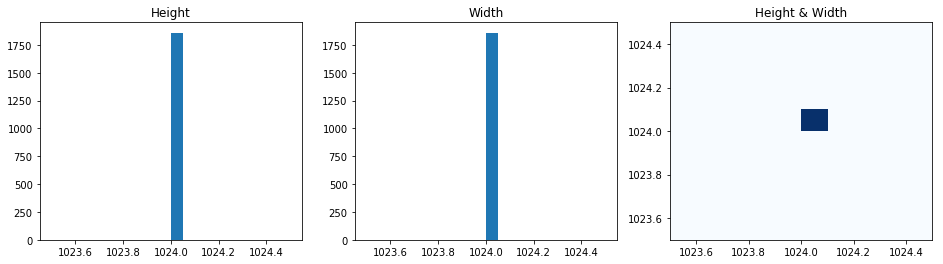

In [12]:
# Image stats
image_shape = np.array([s['shape'] for s in stats])
image_color = np.array([s['color'] for s in stats])
print("Image Count: ", image_shape.shape[0])
print("Height  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 0]), np.median(image_shape[:, 0]),
    np.min(image_shape[:, 0]), np.max(image_shape[:, 0])))
print("Width   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 1]), np.median(image_shape[:, 1]),
    np.min(image_shape[:, 1]), np.max(image_shape[:, 1])))
print("Color   mean (RGB): {:.2f} {:.2f} {:.2f}".format(*np.mean(image_color, axis=0)))

# Histograms
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].set_title("Height")
_ = ax[0].hist(image_shape[:, 0], bins=20)
ax[1].set_title("Width")
_ = ax[1].hist(image_shape[:, 1], bins=20)
ax[2].set_title("Height & Width")
_ = ax[2].hist2d(image_shape[:, 1], image_shape[:, 0], bins=10, cmap="Blues")

### Nuclei per Image Stats

Nuclei/Image
Image area <= 1300**2:  mean: 1.0  median: 1.0  min: 1.0  max: 1.0
Image area <= 1300.0**2: None
Image area <= 1300.0**2: None


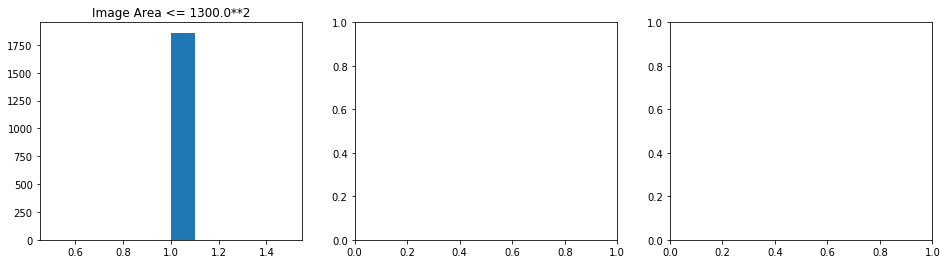

In [19]:
# Segment by image area
image_area_bins = [1300**2, 1300**2, 1300**2]

print("Nuclei/Image")
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(16, 4))
area_threshold = 0
for i, image_area in enumerate(image_area_bins):
    nuclei_per_image = np.array([len(s['bbox']) 
                                 for s in stats 
                                 if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area])
    area_threshold = image_area
    if len(nuclei_per_image) == 0:
        print("Image area <= {:4}**2: None".format(np.sqrt(image_area)))
        continue
    print("Image area <= {:4.0f}**2:  mean: {:.1f}  median: {:.1f}  min: {:.1f}  max: {:.1f}".format(
        np.sqrt(image_area), nuclei_per_image.mean(), np.median(nuclei_per_image), 
        nuclei_per_image.min(), nuclei_per_image.max()))
    ax[i].set_title("Image Area <= {:4}**2".format(np.sqrt(image_area)))
    _ = ax[i].hist(nuclei_per_image, bins=10)

### Nuclei Size Stats


Image Area <= 1300**2
  Total Nuclei:  1860
  Nucleus Height. mean: 109.74  median: 66.00  min: 9.00  max: 1024.00
  Nucleus Width.  mean: 167.05  median: 114.00  min: 13.00  max: 1024.00
  Nucleus Area.   mean: 42000.20  median: 7484.00  min: 140.00  max: 1048576.00


IndexError: too many indices for array

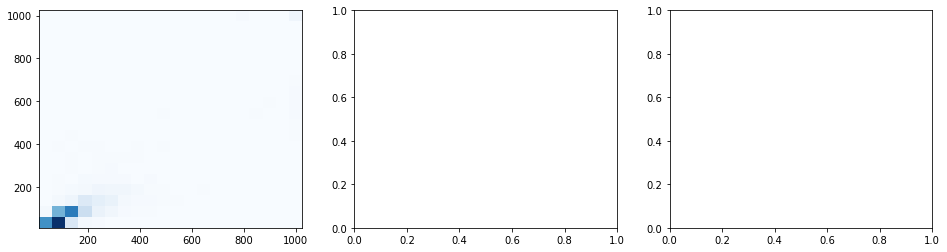

In [20]:
# Nuclei size stats
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(16, 4))
area_threshold = 0
for i, image_area in enumerate(image_area_bins):
    nucleus_shape = np.array([
        b 
        for s in stats if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area
        for b in s['bbox']])
    nucleus_area = nucleus_shape[:, 0] * nucleus_shape[:, 1]
    area_threshold = image_area

    print("\nImage Area <= {:.0f}**2".format(np.sqrt(image_area)))
    print("  Total Nuclei: ", nucleus_shape.shape[0])
    print("  Nucleus Height. mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(nucleus_shape[:, 0]), np.median(nucleus_shape[:, 0]),
        np.min(nucleus_shape[:, 0]), np.max(nucleus_shape[:, 0])))
    print("  Nucleus Width.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(nucleus_shape[:, 1]), np.median(nucleus_shape[:, 1]),
        np.min(nucleus_shape[:, 1]), np.max(nucleus_shape[:, 1])))
    print("  Nucleus Area.   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(nucleus_area), np.median(nucleus_area),
        np.min(nucleus_area), np.max(nucleus_area)))

    # Show 2D histogram
    _ = ax[i].hist2d(nucleus_shape[:, 1], nucleus_shape[:, 0], bins=20, cmap="Blues")

In [25]:
# Nuclei height/width ratio
nucleus_aspect_ratio = nucleus_shape[:, 0] / nucleus_shape[:, 1]
print("Nucleus Aspect Ratio.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(nucleus_aspect_ratio), np.median(nucleus_aspect_ratio),
    np.min(nucleus_aspect_ratio), np.max(nucleus_aspect_ratio)))
plt.figure(figsize=(15, 5))
_ = plt.hist(nucleus_aspect_ratio, bins=100, range=[0, 5])

IndexError: too many indices for array

## Image Augmentation

Test out different augmentation methods

In [22]:
# List of augmentations
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html
augmentation = iaa.Sometimes(0.9, [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])

./cbis_dataset/train/1051/mask
./cbis_dataset/train/1051/mask
./cbis_dataset/train/1051/mask
./cbis_dataset/train/1051/mask


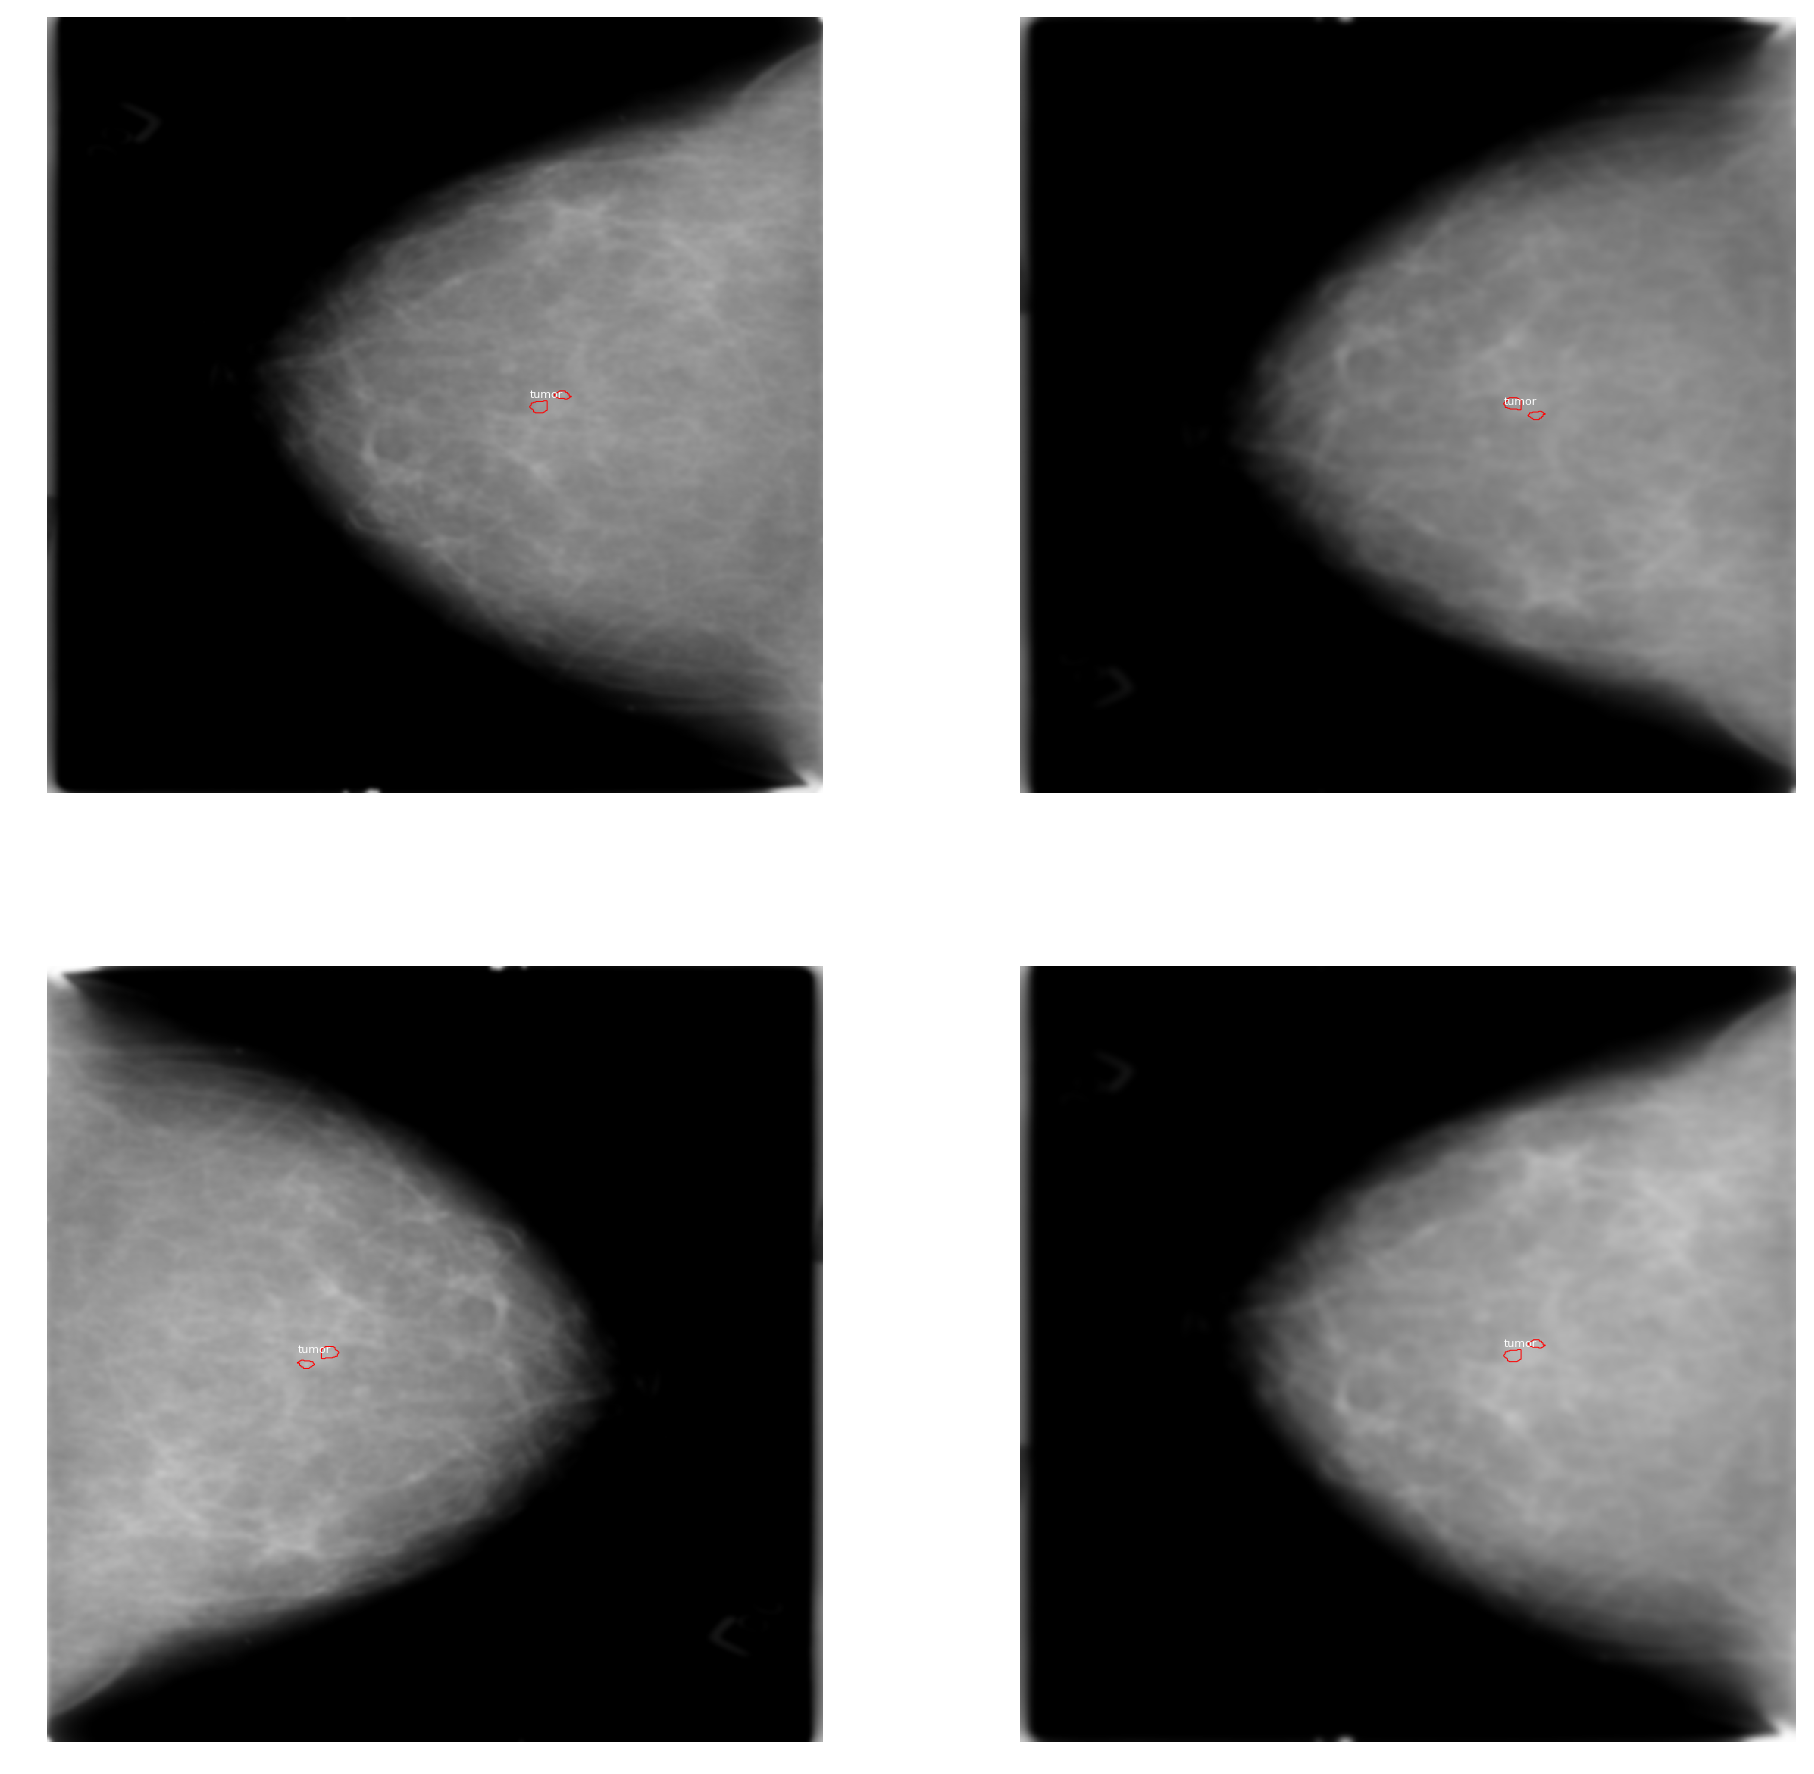

In [35]:
# Load the image multiple times to show augmentations
limit = 4
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False, augment=False, augmentation=augmentation)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)

## Image Crops

Microscoy images tend to be large, but nuclei are small. So it's more efficient to train on random crops from large images. This is handled by `config.IMAGE_RESIZE_MODE = "crop"`.



In [36]:
class RandomCropConfig(nucleus.NucleusConfig):
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

crop_config = RandomCropConfig()

./cbis_dataset/train/186/mask

*** No instances to display *** 

./cbis_dataset/train/186/mask

*** No instances to display *** 

./cbis_dataset/train/186/mask

*** No instances to display *** 

./cbis_dataset/train/186/mask

*** No instances to display *** 



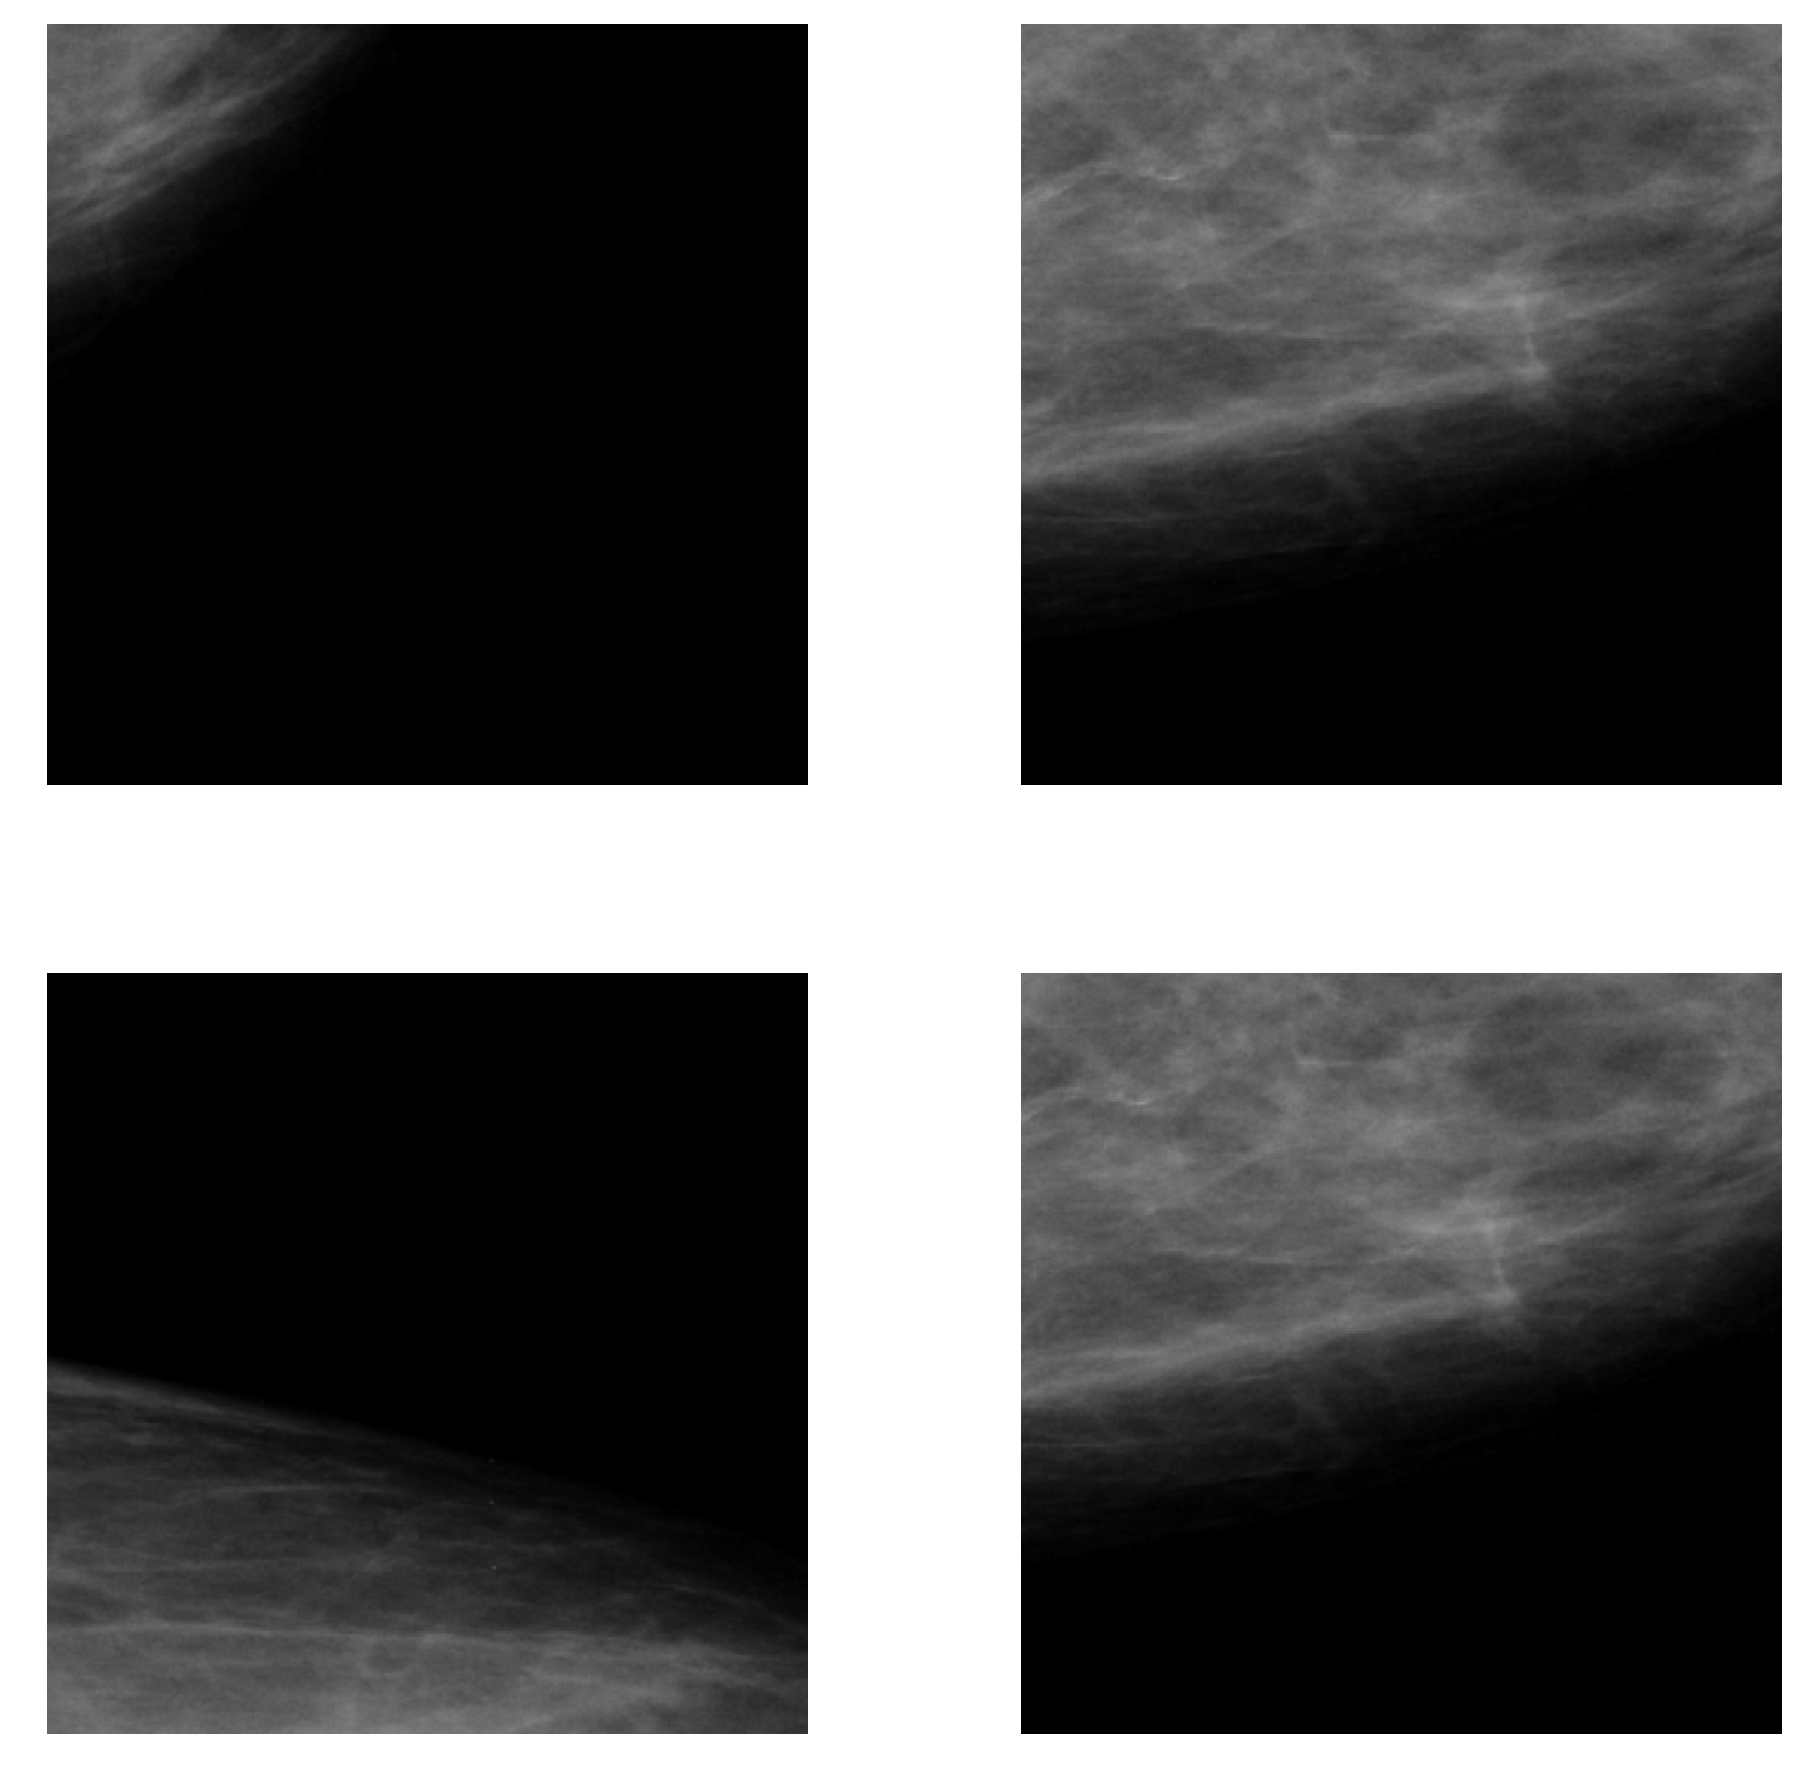

In [37]:
# Load the image multiple times to show augmentations
limit = 4
image_id = np.random.choice(dataset.image_ids, 1)[0]
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, crop_config, image_id, use_mini_mask=False)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)

## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

./cbis_dataset/train/993/mask
image_id:  198 993_train
Original shape:  (1024, 1024, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  414.00000  max:  721.00000  int32


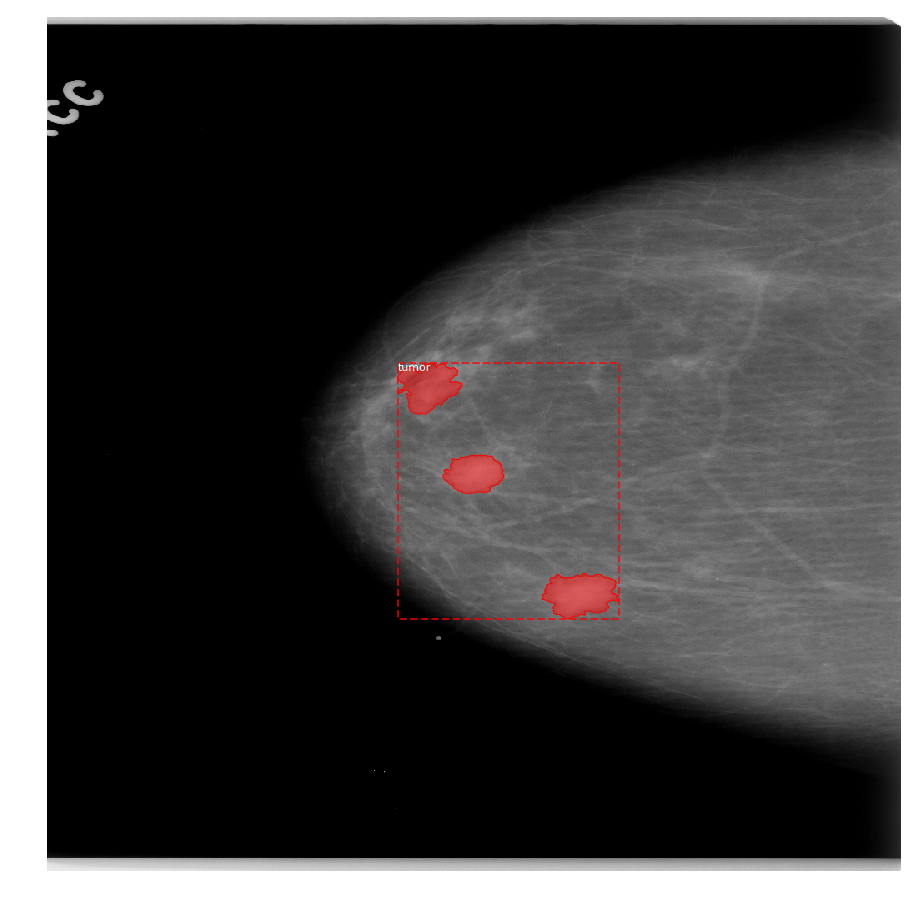

In [49]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

./cbis_dataset/train/1433/mask
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1051.00000  int64
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  540.00000  max:  714.00000  int32
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


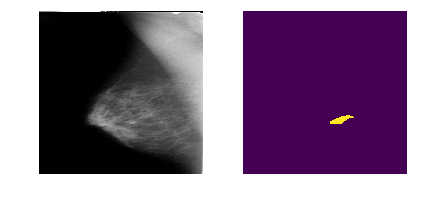

In [50]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

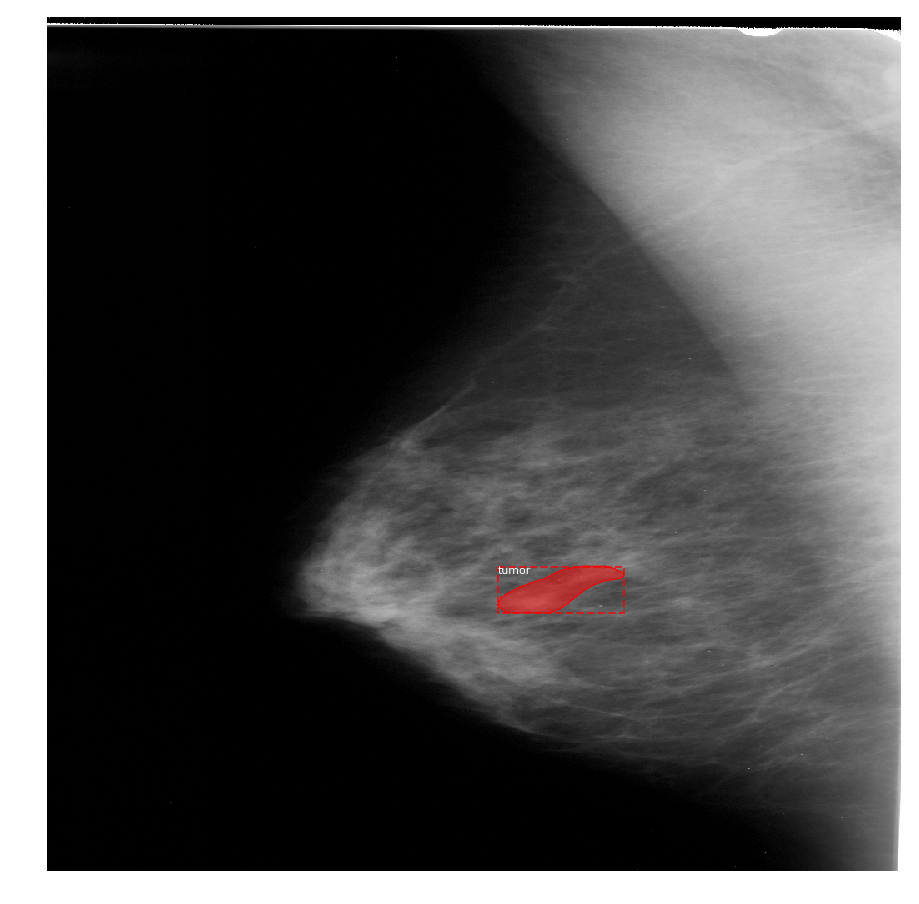

In [52]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

./cbis_dataset/train/1433/mask
mask                     shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


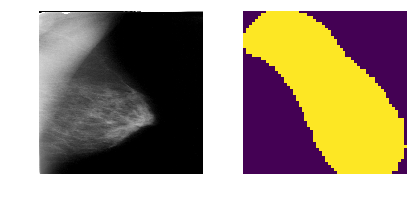

In [54]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

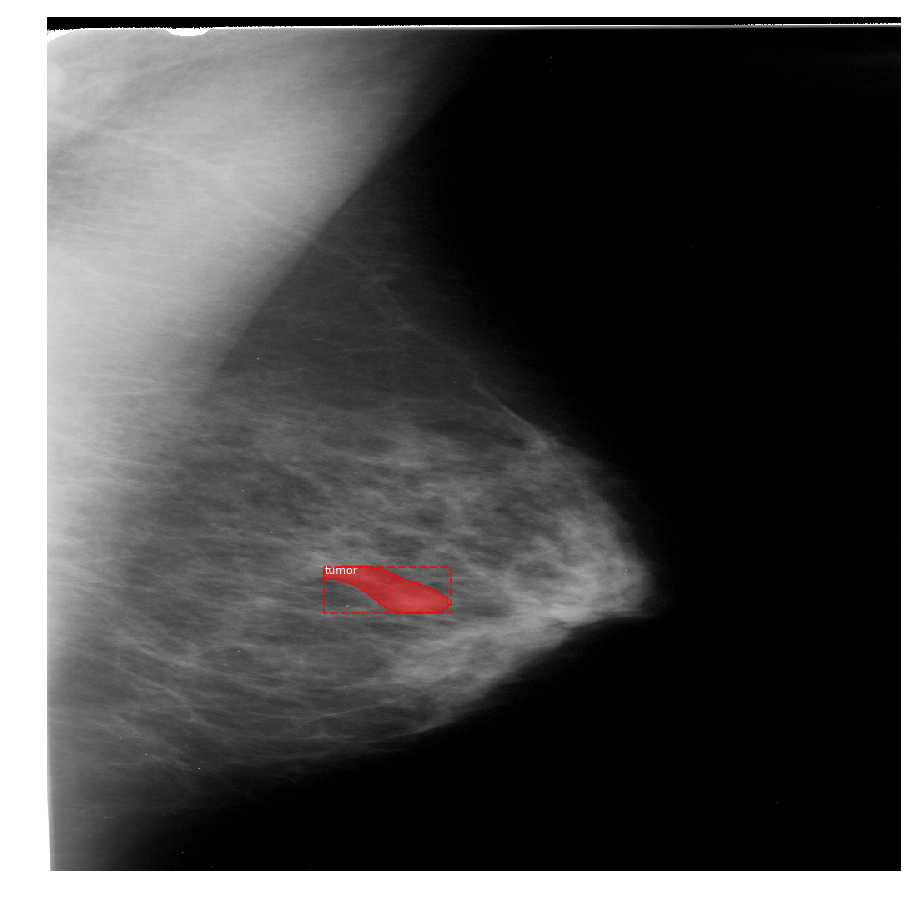

In [55]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

./cbis_dataset/train/1454/mask
Count:  65472
Scales:  (8, 16, 32, 64, 128)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 49152
Anchors in Level 1: 12288
Anchors in Level 2: 3072
Anchors in Level 3: 768
Anchors in Level 4: 192
Level 0. Anchors:  49152  Feature map Shape: [128 128]
Level 1. Anchors:  12288  Feature map Shape: [64 64]
Level 2. Anchors:   3072  Feature map Shape: [32 32]
Level 3. Anchors:    768  Feature map Shape: [16 16]
Level 4. Anchors:    192  Feature map Shape: [8 8]


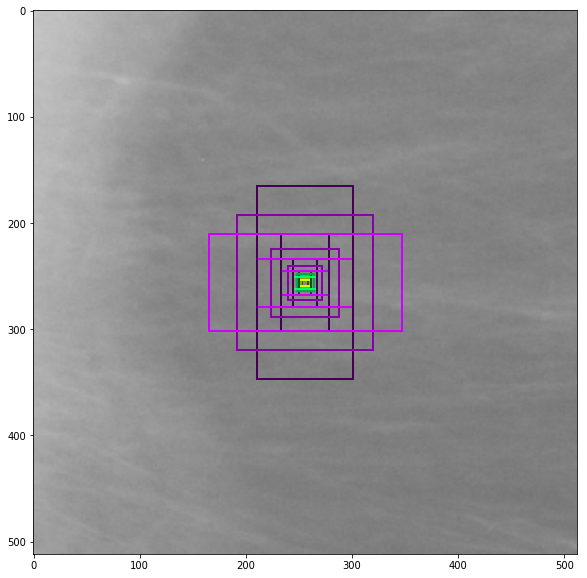

In [56]:
## Visualize anchors of one cell at the center of the feature map

# Load and display random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, crop_config, image_id)

# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, image.shape)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

# Display
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator

In [57]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, crop_config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [24]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
# for i in range(1000):
#     print(i)
#     _, _ = next(g)

In [58]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

./cbis_dataset/train/739/mask
./cbis_dataset/train/408/mask
./cbis_dataset/train/1383/mask
./cbis_dataset/train/126/mask
./cbis_dataset/train/1690/mask
./cbis_dataset/train/1686/mask
./cbis_dataset/train/325/mask
./cbis_dataset/train/1220/mask
./cbis_dataset/train/506/mask
./cbis_dataset/train/600/mask
./cbis_dataset/train/1248/mask
./cbis_dataset/train/686/mask
./cbis_dataset/train/50/mask
./cbis_dataset/train/1367/mask
./cbis_dataset/train/1004/mask
./cbis_dataset/train/466/mask
./cbis_dataset/train/210/mask
./cbis_dataset/train/1068/mask
./cbis_dataset/train/856/mask
./cbis_dataset/train/1753/mask
./cbis_dataset/train/1087/mask
./cbis_dataset/train/1410/mask
./cbis_dataset/train/1062/mask
./cbis_dataset/train/638/mask
rois                     shape: (4, 128, 4)           min:    0.00000  max:  511.00000  int32
mrcnn_class_ids          shape: (4, 128, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 128, 2, 4)        min:   -3.23529  max:    3.

anchors                  shape: (65472, 4)            min:  -90.50967  max:  538.50967  float64
refined_anchors          shape: (1, 4)                min:  102.99998  max:  512.00000  float32
Positive anchors: 1
Negative anchors: 63
Neutral anchors: 65408
BG                     : 86
tumor                  : 42


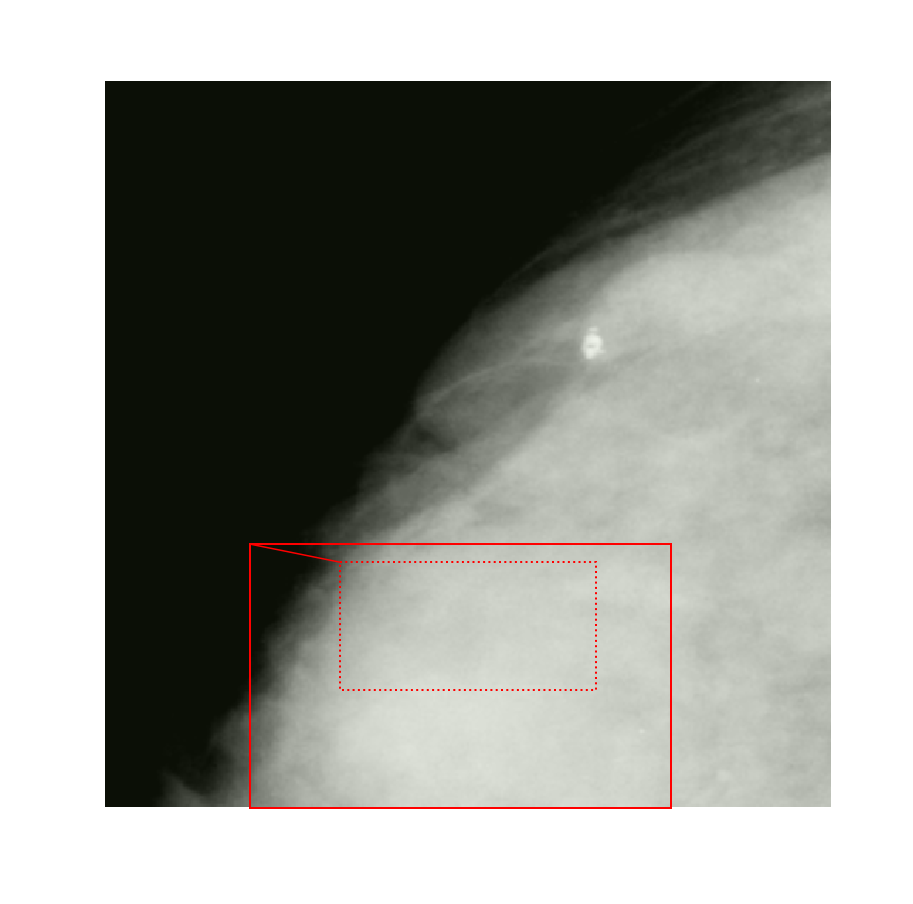

In [59]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

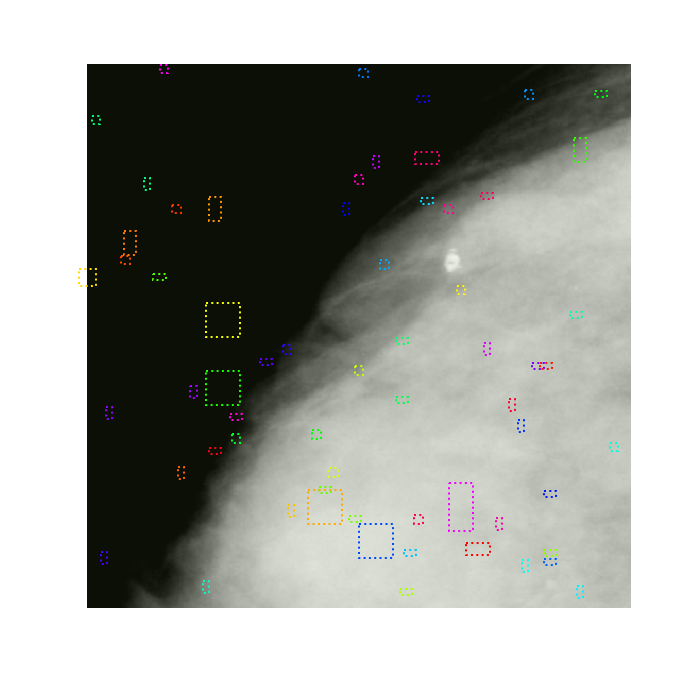

In [60]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

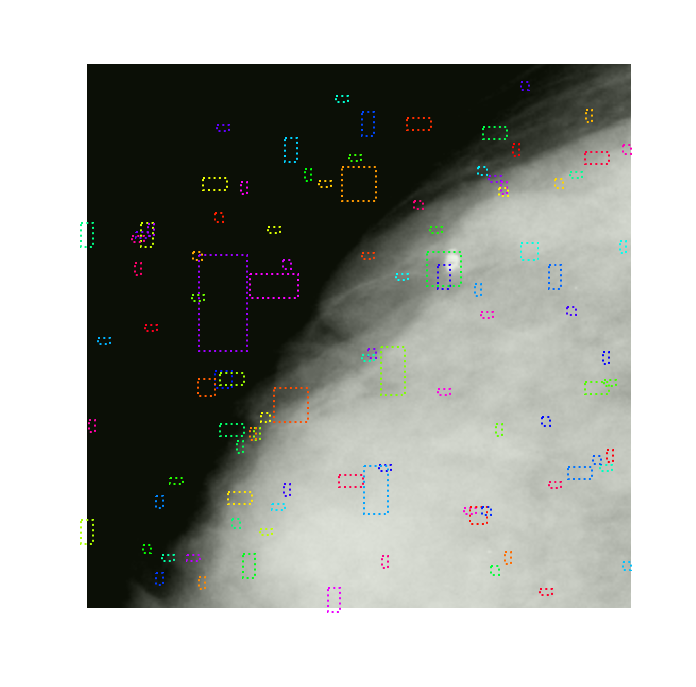

In [61]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Typically, the RPN network generates region proposals (a.k.a. Regions of Interest, or ROIs). The data generator has the ability to generate proposals as well for illustration and testing purposes. These are controlled by the `random_rois` parameter.

Positive ROIs:  42
Negative ROIs:  86
Positive Ratio: 0.33
Unique ROIs: 128 out of 128


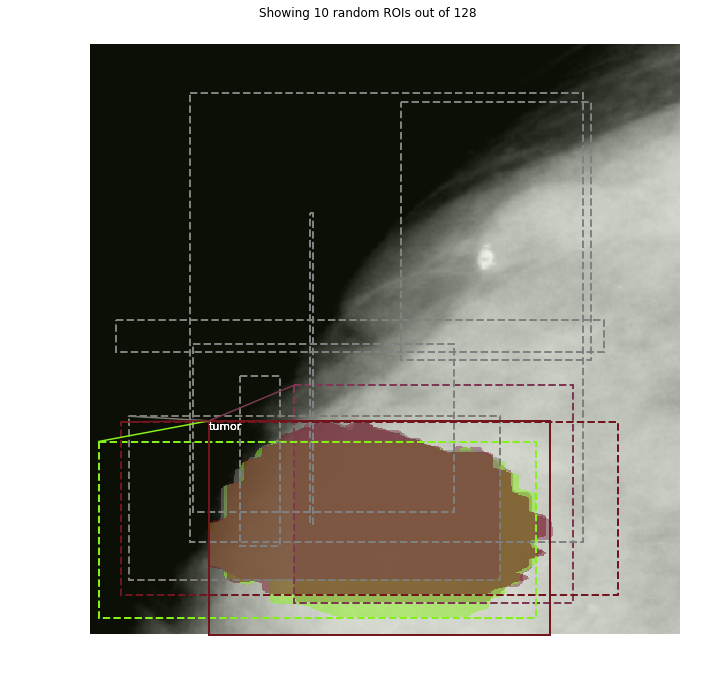

In [62]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

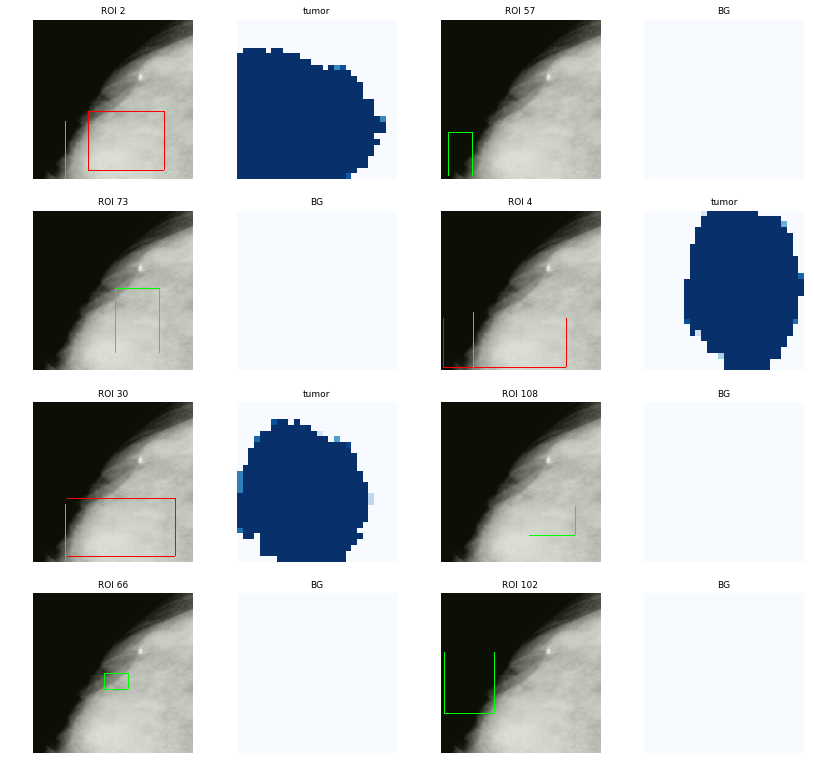

In [63]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [64]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, crop_config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

./cbis_dataset/train/1705/mask
   42  0.33
./cbis_dataset/train/756/mask
./cbis_dataset/train/160/mask
./cbis_dataset/train/1326/mask
./cbis_dataset/train/467/mask
./cbis_dataset/train/30/mask
./cbis_dataset/train/530/mask
./cbis_dataset/train/1710/mask
   42  0.33
./cbis_dataset/train/1242/mask
./cbis_dataset/train/1221/mask
./cbis_dataset/train/1690/mask
   42  0.33
./cbis_dataset/train/795/mask
./cbis_dataset/train/79/mask
./cbis_dataset/train/1852/mask
./cbis_dataset/train/298/mask
./cbis_dataset/train/935/mask
./cbis_dataset/train/956/mask
./cbis_dataset/train/1279/mask
   42  0.33
./cbis_dataset/train/1513/mask
./cbis_dataset/train/1478/mask
   42  0.33
./cbis_dataset/train/1521/mask
   42  0.33
./cbis_dataset/train/263/mask
./cbis_dataset/train/1684/mask
./cbis_dataset/train/384/mask
./cbis_dataset/train/1111/mask
   42  0.33
./cbis_dataset/train/996/mask
./cbis_dataset/train/1384/mask
./cbis_dataset/train/206/mask
   42  0.33
./cbis_dataset/train/90/mask
./cbis_dataset/train/29